In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pickle

external_path=''

In [2]:
class MLP(torch.nn.Module):
    def __init__(self, in_dimension, out_dimension):
        super().__init__()
        self.layer=torch.nn.Linear(in_dimension,out_dimension)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)

In [3]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('aaraki/vit-base-patch16-224-in21k-finetuned-cifar10')

concepts=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

mlp=MLP(768,10)

with torch.no_grad():
    mlp.layer.weight=torch.nn.Parameter(model.classifier.weight)
    mlp.layer.bias=torch.nn.Parameter(model.classifier.bias)

In [6]:
def intermediate_layer_accuracy(concept,layer):
    for k in range(1,11):
        if k==1:
            concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{concept}\\layer{layer}_{k}.pt')
        else:
            concept_activations=torch.cat([concept_activations,torch.load(f'{external_path}\\concept_token_activations\\{concept}\\layer{layer}_{k}.pt')])
    
    acc=0
    count=0
    for k in range(concept_activations.shape[0]):
        prediction=concepts[mlp(concept_activations[k,:]).argmax().item()]
        if prediction==concept:
            acc+=1
        count+=1
    return acc/count

In [14]:
if os.path.exists(f'{external_path}\\intermediate_layer_accuracies'):
    intermediate_layer_accuracies_file=open(f'{external_path}\\intermediate_layer_accuracies','rb')
    intermediate_layer_accuracies=pickle.load(intermediate_layer_accuracies_file)
    intermediate_layer_accuracies_file.close()
else:
    intermediate_layer_accuracies={concept:{} for concept in concepts}

pbar=tqdm(range(13))
for layer in pbar:
    for concept in concepts:
        accuracy=intermediate_layer_accuracy(concept,layer)
        intermediate_layer_accuracies[concept][layer]=accuracy
        pbar.set_description(f'Layer {layer}: {concept} accuracy={accuracy:.4f}')

intermediate_layer_accuracies_file=open(f'{external_path}\\intermediate_layer_accuracies','wb')
pickle.dump(intermediate_layer_accuracies,intermediate_layer_accuracies_file)
intermediate_layer_accuracies_file.close()

Layer 12: truck accuracy=1.0000: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]     


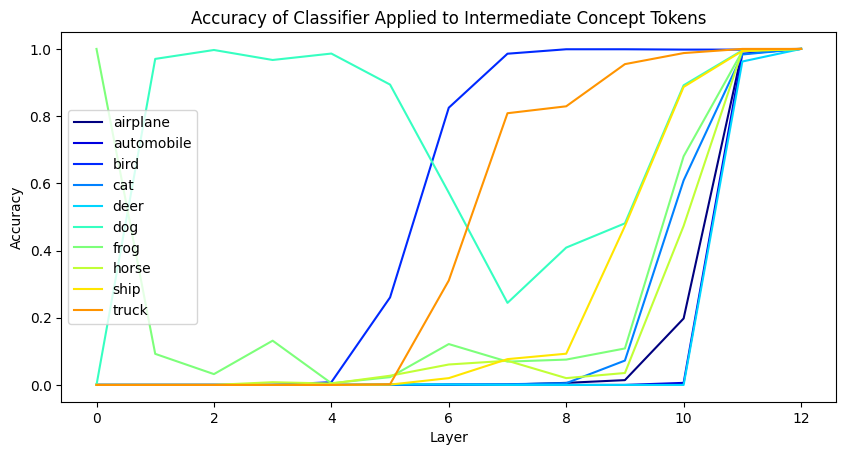

In [26]:
intermediate_layer_accuracies_file=open(f'{external_path}\\intermediate_layer_accuracies','rb')
intermediate_layer_accuracies=pickle.load(intermediate_layer_accuracies_file)
intermediate_layer_accuracies_file.close()

fig,axs=plt.subplots(nrows=1,ncols=1)
fig.set_figwidth(10)

colors=plt.cm.jet(np.linspace(0,0.75,len(intermediate_layer_accuracies.keys())))
for n,concept in enumerate(intermediate_layer_accuracies.keys()):
    axs.plot(intermediate_layer_accuracies[concept].keys(),intermediate_layer_accuracies[concept].values(),color=colors[n],label=concept)
axs.set_title('Accuracy of Classifier Applied to Intermediate Concept Tokens')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Layer')
axs.legend()
plt.show()